<a href="https://colab.research.google.com/github/amalvarezme/AprendizajeMaquina/blob/main/5_DeepLearning/2_DL_Keras_API_funcional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creación de arquitecturas de aprendizaje profundo mediante API funcional de Keras.

- Se presentan los consideraciones básicas respecto a la [API funcional de Keras](https://keras.io/guides/functional_api/) para la implementación de modelos de redes profundas con TensorFlow.



In [1]:
import tensorflow as tf #importar tensorflow
print(tf.__version__)

2.13.0


- Se utilizará la base de datos Fashion Mnist nuevamente, normalizando las imágenes de 0 a 1.

In [2]:
train, test = tf.keras.datasets.fashion_mnist.load_data()
images, labels = train

4422102/4422102 [==============================] - 0s 0us/step


- Se presenta un ejemplo de la base de datos

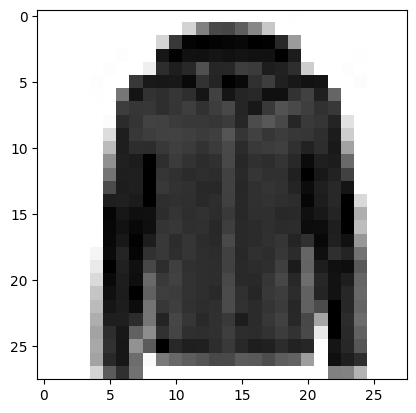

In [3]:
import matplotlib.pyplot as plt
plt.imshow(images[5000,:,:],cmap= 'binary')
plt.show()

In [4]:
import numpy as np
print(np.unique(labels)) #etiquetas
print(images.shape) #tamaño de las imágenes

[0 1 2 3 4 5 6 7 8 9]
(60000, 28, 28)


In [5]:
Xtrain, ytrain = train
Xtrain = Xtrain/255 # tipo flotante, normalizados de 0 a 1
Xtest, ytest = test
Xtest = Xtest/255 # tipo flotante, normalizados de 0 a 1

- En el cuaderno introductorio a redes neuronales con tensorflow se planteó la construcción de modelos mediante secuencia de capas:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 red1 (Dense)                (None, 200)               157000    
                                                                 
 hred2 (Dense)               (None, 50)                10050     
                                                                 
 output (Dense)              (None, 10)                510       
                                                                 
Total params: 167560 (654.53 KB)
Trainable params: 167560 (654.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


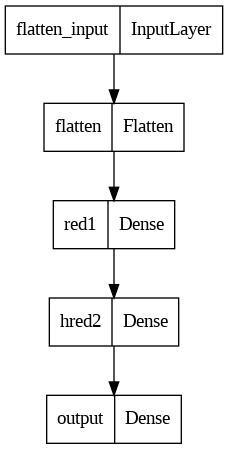

In [6]:
#definir arquitectura secuencial
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2])),
    tf.keras.layers.Dense(200,activation="relu", name='red1'),
    tf.keras.layers.Dense(50, activation="tanh",name='hred2'),
    tf.keras.layers.Dense(10,activation='softmax',name='output')
])

model.summary() # resumen del modelo
tf.keras.utils.plot_model(model) #diagrama del modelo

- Aunque la implementacióm mediante secuencia es intuitiva, no permite realizar conexiones flexibles entre capas.

- En ese sentido, Keras permite crear capas bajo el principio de funciones y argumentos, como se muestra a continuación.

**Nota**: a diferencia de la estructura secuencial, en la API funcional se debe indicar la capa o capas de entrada y la capa o capas de salida para crear el grafo computacional de forma apropiada.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 entrada (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 h1 (Dense)                  (None, 200)               157000    
                                                                 
 h2 (Dense)                  (None, 50)                10050     
                                                                 
 output (Dense)              (None, 10)                510       
                                                                 
Total params: 167560 (654.53 KB)
Trainable params: 167560 (654.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


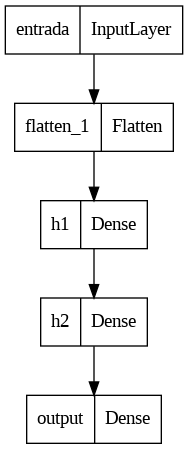

In [7]:
#arquitectura funcional
#capa de entrada
input_l = tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2]), name='entrada')
#capa de aplanamiento de las imágenes
flatten = tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2]))(input_l)#argumento de entrada
#capas densas
h1 = tf.keras.layers.Dense(200,activation='tanh',name='h1')(flatten)#argumento de entrada
h2 = tf.keras.layers.Dense(50,activation='tanh',name='h2')(h1)
#capa de salida
output = tf.keras.layers.Dense(10,activation="softmax",name='output')(h2)
#crear modelo según conexiones tipo funcionales
model_fun = tf.keras.Model(inputs=input_l,outputs=output)

#resumen y gráfica del modelo
model_fun.summary()
tf.keras.utils.plot_model(model_fun)


# La API funcional permite realizar conexiones más flexibles

- En el siguiente ejemplo se crea un modelo con una entrada y dos salidas con interconexiones flexibles:

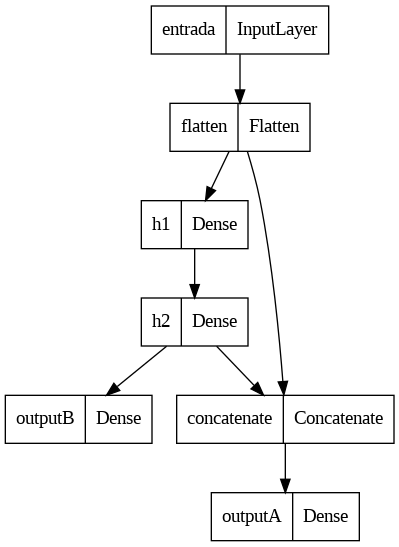

In [8]:
#arquitectura funcional 2
tf.keras.backend.clear_session()
input_l = tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2]), name='entrada')
flatten = tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2]))(input_l)

h1 = tf.keras.layers.Dense(200,activation='tanh',name='h1')(flatten)
h2 = tf.keras.layers.Dense(50,activation='tanh',name='h2')(h1)
#capa que concatena caracterísitacas extraídas en h2 con imágenes de entrada
concat = tf.keras.layers.concatenate([h2,flatten])
#se crean dos salidas:
output_A = tf.keras.layers.Dense(10,activation="softmax",name='outputA')(concat)#desde concatenación
output_B = tf.keras.layers.Dense(10,activation="softmax",name='outputB')(h2)#desde h2
#las entradas y salidas se ingresan como listas
model_fun = tf.keras.Model(inputs=input_l,outputs=[output_A, output_B])
#model_fun.summary()
tf.keras.utils.plot_model(model_fun)

**Nota**: si se cuenta con varias salidas se puede definir un mismo costo para cada salida, o una lista con los costos requeridos. Además, en la lista `loss_weights` se puede especificar el valor del peso asociado al costo de cada salida en el intervalo [0,1].

In [9]:
model_fun.compile(loss="sparse_categorical_crossentropy", #custom_loss(),#custom_loss(),#"sparse_categorical_crossentropy",
              optimizer="Adam",
              metrics="accuracy") #f1, precision, recall, crossentropy


- El entrenamiento se realiza de igual forma al utilizado con el modelo secuencial.

- Como se fijaron dos salidas, se debe ingresar una lista para los argumentos ytrain.

In [10]:
history = model_fun.fit(Xtrain, [ytrain,ytrain] , epochs=10,batch_size=64, # 32, 64, 128, 256
                    validation_split=0.3) # se fija el conjunto de validación como el 20% del de train

Epoch 1/10
657/657 [==============================] - 16s 10ms/step - loss: 1.0941 - outputA_loss: 0.5677 - outputB_loss: 0.5264 - outputA_accuracy: 0.8033 - outputB_accuracy: 0.8119 - val_loss: 0.8668 - val_outputA_loss: 0.4350 - val_outputB_loss: 0.4318 - val_outputA_accuracy: 0.8463 - val_outputB_accuracy: 0.8461
Epoch 2/10
657/657 [==============================] - 4s 7ms/step - loss: 0.7937 - outputA_loss: 0.4015 - outputB_loss: 0.3922 - outputA_accuracy: 0.8552 - outputB_accuracy: 0.8575 - val_loss: 0.7995 - val_outputA_loss: 0.4039 - val_outputB_loss: 0.3955 - val_outputA_accuracy: 0.8541 - val_outputB_accuracy: 0.8556
Epoch 3/10
657/657 [==============================] - 4s 5ms/step - loss: 0.7132 - outputA_loss: 0.3599 - outputB_loss: 0.3533 - outputA_accuracy: 0.8686 - outputB_accuracy: 0.8700 - val_loss: 0.7740 - val_outputA_loss: 0.3861 - val_outputB_loss: 0.3879 - val_outputA_accuracy: 0.8563 - val_outputB_accuracy: 0.8569
Epoch 4/10
657/657 [==============================

- Se presentan las curvas de desempeño:

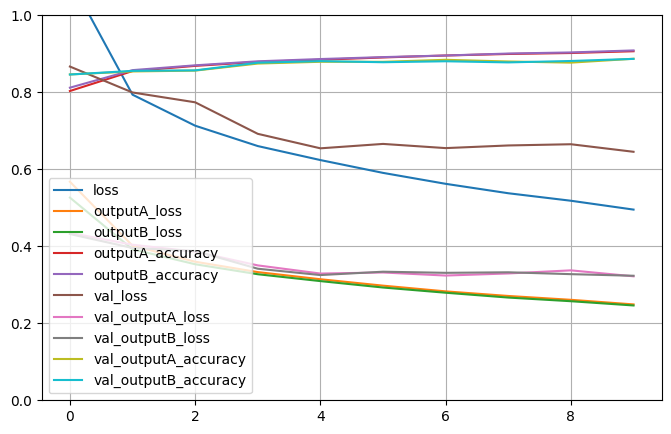

In [11]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
#save_fig("keras_learning_curves_plot")
plt.show()

- Como el modelo generado presenta dos salidas, el rendimiento se discrimina por cada salida y el acumulado.

- A la hora de predecir la salida para una nueva muestra, se debe tener en cuenta la cantidad de salidas fijadas.

In [12]:
yestA,yestB = model_fun.predict(Xtest)
print(yestA.shape,yestB.shape)#salidas tipo 1 -K probabilidad de membresia a cada clase

313/313 [==============================] - 1s 2ms/step
(10000, 10) (10000, 10)


In [13]:
print(yestA[0].argmax(),ytest[0])#para estimar la etiqueta ordinal se encuentra el max por columnas

9 9


In [14]:
scoreA = model_fun.evaluate(Xtest,ytest)#evaluacion
print(scoreA)

313/313 [==============================] - 1s 3ms/step - loss: 0.6974 - outputA_loss: 0.3483 - outputB_loss: 0.3491 - outputA_accuracy: 0.8783 - outputB_accuracy: 0.8745
[0.6973525881767273, 0.3482735753059387, 0.34907853603363037, 0.8783000111579895, 0.8744999766349792]


# Grafiquemos los pesos respecto a las dimensiones de la imagen original

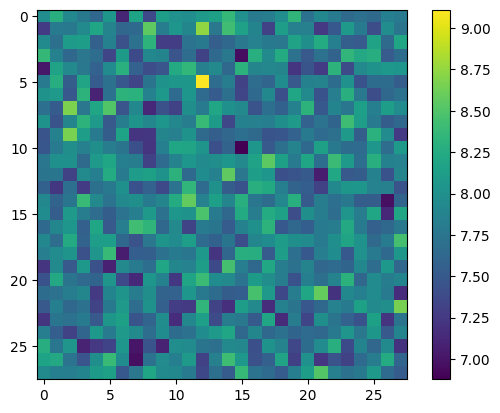

In [15]:
#se busca identificar las entradas más relevantes para la red
plt.imshow(abs(model.layers[1].get_weights()[0]).sum(axis=1).reshape(28,28))
plt.colorbar()
plt.show()

In [16]:
model.layers[1].get_weights()[1].shape # accediendo a los bias

(200,)

# Salidas parciales de la red

- La estrategia funcional nos permite acceder a partes intermedias de la red para encontrar mapas de características y verificar el aprendizaje de la representación.

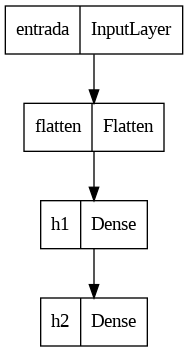

In [17]:
#crear nuevo modelo con salida parcial
model_B = tf.keras.Model(inputs=model_fun.inputs,outputs=model_fun.get_layer('h2').output) #se accede a capas por nombre
tf.keras.utils.plot_model(model_B) # modelo ya esta ajustado!


In [18]:
z = model_B.predict(Xtest) # salida en h2
z.shape

313/313 [==============================] - 0s 1ms/step


(10000, 50)

### Dado que se fijaron 50 unidades, se pueden utilizar técnicas de reducción de dimensión para visualizar los patrones intermedios de la red en 2D.

In [19]:
from sklearn.decomposition import PCA
zpca = PCA(n_components=2).fit_transform(z)
zpca.shape

(10000, 2)

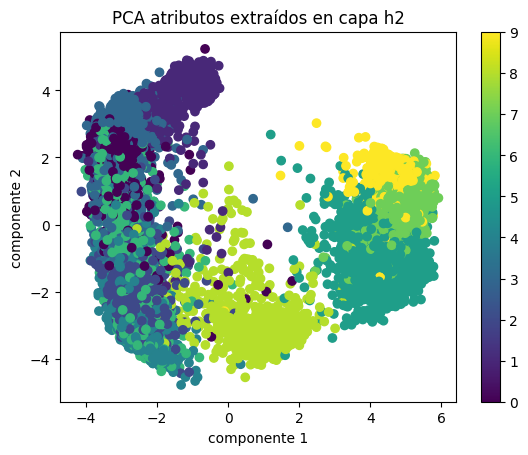

In [20]:
plt.scatter(zpca[:,0],zpca[:,1],c=ytest)
plt.colorbar()
plt.xlabel('componente 1')
plt.ylabel('componente 2')
plt.title('PCA atributos extraídos en capa h2')
plt.show()

In [21]:
#plot mnist 2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def plot_mnist_2d(Z,y,images,img_w=28,img_h=28,zoom=0.5,cmap='jet'):
    fig, ax = plt.subplots(figsize=(16,10))
    for i in range(Z.shape[0]):
        #print('img',i+1,'/',Z.shape[0])
        image = images[i].reshape((img_w, img_h))
        im = OffsetImage(image, zoom=zoom,cmap=cmap)
        ab = AnnotationBbox(im, (Z[i,0], Z[i,1]), xycoords='data', frameon=False)
        ax.add_artist(ab)
        ax.update_datalim([(Z[i,0], Z[i,1])])
        ax.autoscale()

- También, podemos revisar la distribución de las imágenes en el espacio proyectado:

Text(0.5, 1.0, 'PCA atributos extraídos en capa h2')

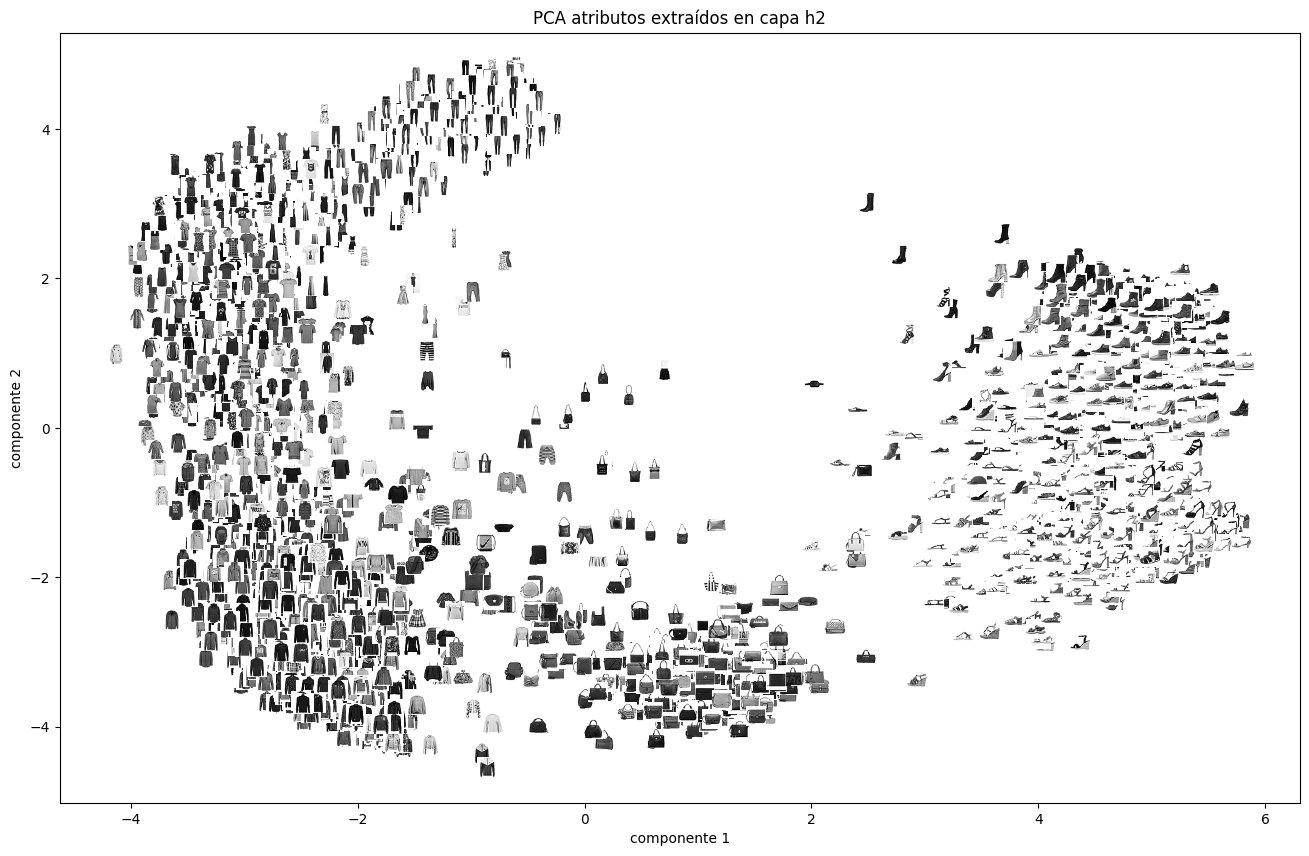

In [22]:
Ni =4000 # graficar Ni muestras como imagenes en espacio 2D
ind = np.random.randint(0,ytest.shape[0],Ni)
plot_mnist_2d(zpca[ind],ytest[ind],Xtest[ind],img_w=28,img_h=28,zoom=0.5,cmap='binary')
plt.xlabel('componente 1')
plt.ylabel('componente 2')
plt.title('PCA atributos extraídos en capa h2')

# Ejercicio:

- Grafique el espacio proyectado de PCA en 2D (etiquetas e imágenes) para los atributos aprendidos por la capa de concatenación.

- Repita el proceso aplicando la técnica de reducción de dimensión [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). Nota: escoja un subconjunto aleatorio de 4000 datos para que el algoritmo t-SNE converja sin problemas de memoría.

- Plantee una nueva arquitectura tipo funcional utilizando capas convolucionales (Ver cuaderno [CNNs](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/5_DeepLearning/3_Introduccion_CNN.ipynb)) para el entrenamiento de la base de datos Mnist-digitos, utilizando tres entradas: i) imágenes limpias, ii) y iii) imágenes con ruido blanco Gaussiano ante diferentes varianzas, y dos salidas i) estimación del digito, ii) estimación número par número impar.

In [23]:
#Ayuda de código:
#cargar fashion mnist o mnist
#(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_valid = X_train[:-55000], X_train[-55000:]
y_train, y_valid = y_train[:-55000], y_train[-55000:]

X_train = X_train[..., np.newaxis]/255.
X_valid = X_valid[..., np.newaxis]/255.
X_test = X_test[..., np.newaxis]/255.
print(X_train.shape,X_valid.shape,X_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(5000, 28, 28, 1) (55000, 28, 28, 1) (10000, 28, 28, 1)


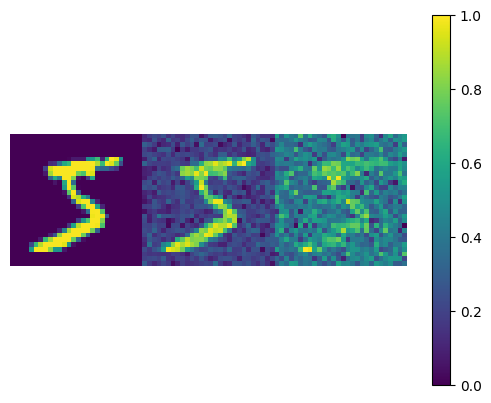

In [24]:
#crear entradas con y sin ruido
from sklearn.preprocessing import MinMaxScaler

var_ = [0.01,0.25]
inputs_train = [X_train]
inputs_valid = [X_valid]
inputs_test = [X_test]

#recorrer varianzas
for var_i in var_:
    dim = X_train.shape
    #definir ruido
    tmp = X_train + (np.sqrt(var_i)*np.random.randn(X_train.shape[0],dim[1],dim[2],dim[3]))
    tmp = MinMaxScaler().fit_transform(tmp.reshape(dim[0],-1).T).T #fijar señal con ruido de 0 a 1
    inputs_train += [tmp.reshape(dim)]

    dim = X_valid.shape
    tmp = X_valid + (np.sqrt(var_i)*np.random.randn(X_valid.shape[0],dim[1],dim[2],dim[3]))
    tmp = MinMaxScaler().fit_transform(tmp.reshape(dim[0],-1).T).T
    inputs_valid += [tmp.reshape(dim)]

    dim = X_test.shape
    tmp = X_test + (np.sqrt(var_i)*np.random.randn(X_test.shape[0],dim[1],dim[2],dim[3]))
    tmp = MinMaxScaler().fit_transform(tmp.reshape(dim[0],-1).T).T
    inputs_test += [tmp.reshape(dim)]


plt.imshow(np.c_[inputs_train[0][0,:,:,0],inputs_train[1][0,:,:,0],inputs_train[2][0,:,:,0]])
plt.axis('off')
plt.colorbar()
plt.show()

In [25]:
#veector de salida par o impar
ytrain_B = (ytrain % 2)
print(ytrain_B[10:])
print(ytrain[10:])

[0 1 1 ... 1 0 1]
[0 9 5 ... 3 0 5]


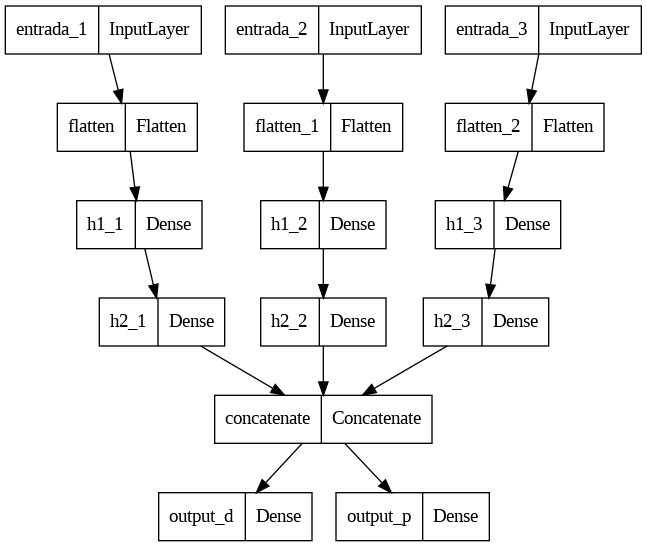

In [26]:
#arquitectura funcional 2 - Ayuda de código con capas densas - cambiar a capas cnn
tf.keras.backend.clear_session()
input_1 = tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2]), name='entrada_1')
input_2 = tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2]), name='entrada_2')
input_3 = tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2]), name='entrada_3')

flatten_1 = tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2]))(input_1)
flatten_2 = tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2]))(input_2)
flatten_3 = tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2]))(input_3)

h1_1 = tf.keras.layers.Dense(200,activation='tanh',name='h1_1')(flatten_1)
h2_1 = tf.keras.layers.Dense(50,activation='tanh',name='h2_1')(h1_1)

h1_2 = tf.keras.layers.Dense(200,activation='tanh',name='h1_2')(flatten_2)
h2_2 = tf.keras.layers.Dense(50,activation='tanh',name='h2_2')(h1_2)

h1_3 = tf.keras.layers.Dense(200,activation='tanh',name='h1_3')(flatten_3)
h2_3 = tf.keras.layers.Dense(50,activation='tanh',name='h2_3')(h1_3)

#capa que concatena caracterísitacas extraídas en h2 con imágenes de entrada
concat = tf.keras.layers.concatenate([h2_1,h2_2,h2_3])
#se crean dos salidas:
output_d = tf.keras.layers.Dense(10,activation="softmax",name='output_d')(concat)#desde concatenación
output_p = tf.keras.layers.Dense(1,activation="sigmoid",name='output_p')(concat)#desde h2
#las entradas y salidas se ingresan como listas
model_fun2 = tf.keras.Model(inputs=[input_1,input_2,input_3],outputs=[output_d, output_p])
#model_fun.summary()
tf.keras.utils.plot_model(model_fun2)

In [27]:
#Entrenar y ajustar el modelo, revisar rendimientos en cada salida